In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()

In [3]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

## update data
def filter_df_long(df):
    max=39
    thresh=8
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[data.index.get_level_values('age').isin(ages_greater)]

In [4]:
# arrange male ontogeny data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid','mouse']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df_long(data).groupby(['age','uuid','mouse']).mean()
data = data.query('age<100')
long_data = data[sorted(data.columns)].copy()

In [6]:
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_data.index.get_level_values('age').unique())
# Group entries by week
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]

In [7]:
long_data = long_data[long_data.index.get_level_values('age').isin(lowest_day_entries)]

long_data = long_data.rename_axis(index={'age': 'age_old'})

In [8]:
long_data['age'] = np.floor(long_data.index.get_level_values('age_old')).astype(int)
long_data.set_index('age',inplace=True, append=True)

In [9]:
# use only common ages
long_ages = long_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(long_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['exp'] = 'ont'
m_data.set_index('exp',inplace=True,append=True)

long_data = long_data.loc[long_data.index.get_level_values('age').isin(cages)]
long_data['exp'] = 'long'
long_data.set_index('exp',inplace=True,append=True)

In [10]:
m_data= m_data.groupby('age').mean()
long_data = long_data.groupby('age').mean()

data=pd.concat([m_data,long_data])
#data.set_index('sex',inplace=True,append=True)

In [13]:
#correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman').to_numpy()

In [14]:
# Calculate p-values using scipy's pearsonr function
from scipy.stats import spearmanr
correlation_matrix = m_data.corrwith(long_data, axis=0, method='spearman')

p_values = m_data.apply(lambda col: spearmanr(col, long_data[col.name])[1]) #change by number of syllables used

#colors = ['purple' if value > 0 else 'orange' for value in new_diff]

# Combine results into a DataFrame
result_df = pd.DataFrame({'Correlation': correlation_matrix, 'P-Value': p_values})

In [15]:
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)

In [16]:
sorted_result_df['P-Value']*40

24     0.000017
23     0.000123
6      0.000195
20     0.001101
18     0.003655
0      0.027586
4      0.036292
27     0.043244
30     0.055656
1      0.110975
10     0.136973
32     0.156848
7      0.260398
17     0.260398
5      0.276427
38     0.293223
8      0.368582
11     0.389598
28     0.389598
9      0.509098
12     0.509098
3      0.871061
39     1.187060
34     1.779356
22     2.478040
2      2.657052
31     2.657052
35     2.942834
13     6.737310
26     7.093686
14     7.462175
37    16.502647
29    16.804187
36    25.184818
15    26.656045
21    31.230182
19    33.192484
25    35.577837
33    32.011839
16     2.307954
Name: P-Value, dtype: float64

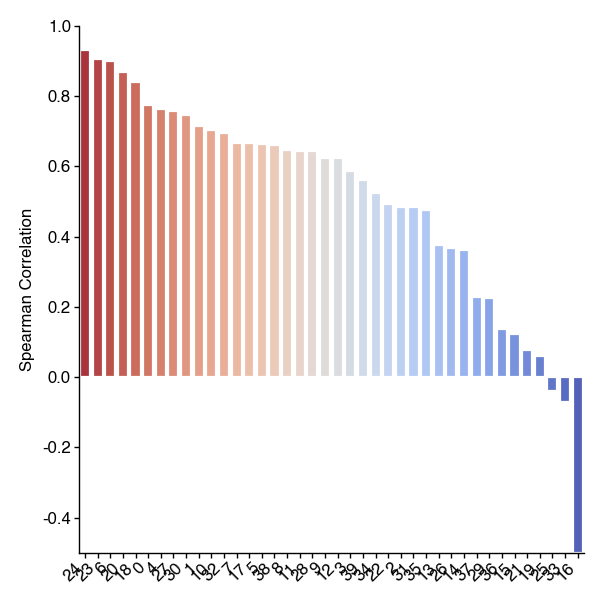

In [17]:
# Create a DataFrame from the correlation values list
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)
sns.barplot(x=list(range(len(sorted_result_df))), y='Correlation', data=sorted_result_df, dodge=True, palette ="coolwarm_r" )
plt.xticks(rotation=45, ha='right')
#plt.title('Spearman Correlation between Columns of df1 and df2')
#plt.xlabel('Columns in df1')
plt.ylim([-0.5,1])
plt.ylabel('Spearman Correlation')
ax.set_xticklabels(sorted_result_df.index.values)
plt.tight_layout()
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'ovl_syll_crosscorr.pdf')

In [21]:
len(palette)

40

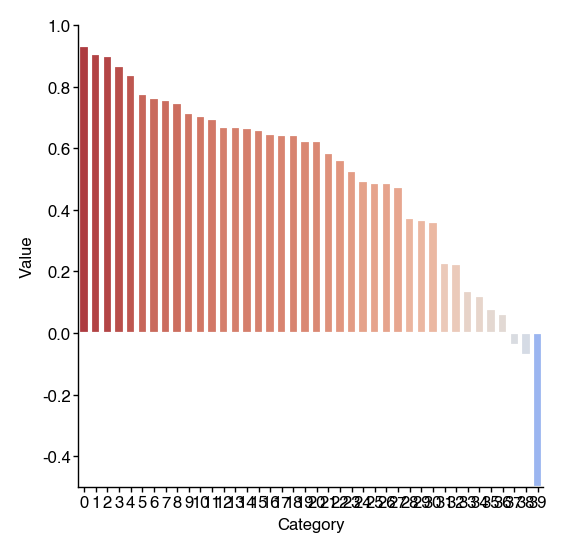

In [27]:
# Create a DataFrame from the correlation values list
from matplotlib.colors import TwoSlopeNorm
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)

df = sorted_result_df.copy()
df['category'] =  -df['Correlation'].rank()
df['value'] = df['Correlation']

# Assume you have your data in a DataFrame called 'df'
# with columns 'category' and 'value'

# Get the minimum and maximum values for normalization
min_val = -1
max_val = 1

#min_val = df['value'].min()
#max_val = df['value'].max()

# Create a TwoSlopeNorm object with the desired center value (0 in this case)
norm = TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)

# Create a colormap object based on 'RdBu_r'
cmap = plt.cm.coolwarm

# Map the normalized values to colors using the colormap
colors = cmap(norm(df['value']))

# Create a custom color palette using the mapped colors
palette = sns.color_palette(colors)

# Create the barplot using Seaborn with the custom color palette
ax = sns.barplot(x=list(range(len(sorted_result_df))), y='value', data=df, palette=palette)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Value')
#plt.title('Barplot with Custom Color Palette')
plt.ylim([-0.5,1])
sns.despine()
# Show the plot
plt.show()
fig.savefig(c.dana_save_path / "fig4"/ 'ovl_syll_crosscorr_colorchange.pdf')

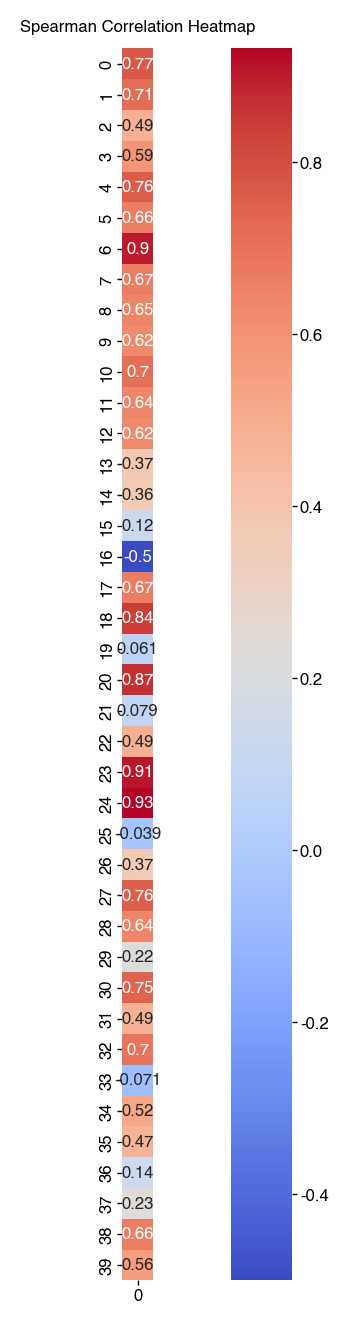

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Spearman Correlation Heatmap")
plt.show()